# Import Packages

In [1]:
from eurostatapiclient import EurostatAPIClient

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns

sns.set()

# Get EU GDP Data

In [2]:
# Choose service version : only v2.1 is currently available
VERSION = 'v2.1'

# Only json is currently available
FORMAT = 'json'

# Specify language : en, fr, de
LANGUAGE = 'en'

client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [3]:
params = {'unit': 'CLV10_MEUR', 'na_item': 'B1GQ', 'geo': 'EA', 's_adj': 'SCA'}
filtered_dataset = client.get_dataset('namq_10_gdp', params=params)
filtered_dataframe = filtered_dataset.to_dataframe()
filtered_dataframe.head()

,values,unit,s_adj,na_item,geo,time
0,NaN,CLV10_MEUR,SCA,B1GQ,EA,1975Q1
1,NaN,CLV10_MEUR,SCA,B1GQ,EA,1975Q2
2,NaN,CLV10_MEUR,SCA,B1GQ,EA,1975Q3
3,NaN,CLV10_MEUR,SCA,B1GQ,EA,1975Q4
4,NaN,CLV10_MEUR,SCA,B1GQ,EA,1976Q1


In [4]:
dfEU_GDP = filtered_dataframe[['values', 'time']].dropna()
dfEU_GDP.columns = ['GDP', 'Date']
dfEU_GDP.index = dfEU_GDP['Date']
dfEU_GDP = dfEU_GDP.drop('Date', axis=1)
dfEU_GDP.head() 

,GDP
Date,
1995Q1,1768557.1
1995Q2,1778159.1
1995Q3,1782293.6
1995Q4,1788868.7
1996Q1,1790962.0


# Transform GDP to Growth Rate

In [5]:
# Transform GDP in Annualized Growth Rate
dfEU_GDP=pd.DataFrame((dfEU_GDP), columns=['GDP'])
dfEU_Growth = pd.DataFrame(((np.log(dfEU_GDP['GDP']).diff())*400).dropna()) #Multiply by 4*100 to obtain annualized growth rate from quarterly date
dfEU_Growth.columns = ['Growth']
dfEU_Growth.index = dfEU_Growth.index.rename('Date')
dfEU_Growth.index = pd.PeriodIndex(dfEU_Growth.index, freq='Q')
dfEU_Growth.head()

,Growth
Date,
1995Q2,2.165840
1995Q3,0.928983
1995Q4,1.472934
1996Q1,0.467799
1996Q2,3.111440


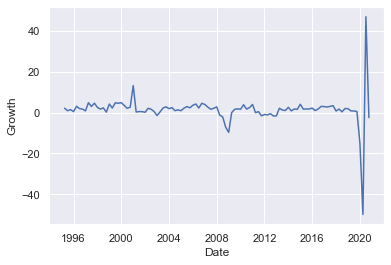

In [6]:
sns.lineplot(x=dfEU_Growth.index.to_timestamp(), y=dfEU_Growth['Growth']);

# Time Series Analysis

In [7]:
# Test Stationarity
adfuller(dfEU_Growth)

(-3.8417793052532954,
 0.0025076462589031937,
 2,
 100,
 {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349},
 617.9834457470527)

The null hypothesis that a unit root is present in a time series is rejected, therefore the series is stationary.

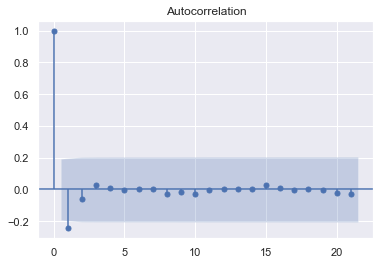

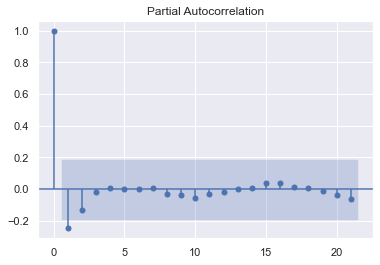

In [8]:
# Autocovariance and Partial Autocovariance
plot_acf(dfEU_Growth), plot_pacf(dfEU_Growth);

The autocovariance and partial autocovariance functions can be used to determine the order of the ARIMA process. As no order can be easily distinguished here, I pick between an ARIMA(1,0,0), ARIMA(0,0,1), and ARIMA(1,0,1) by using the Bayesian information criterion (BIC).

In [9]:
mod=ARIMA(dfEU_Growth, order=(1,0,0)).fit()
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                 Growth   No. Observations:                  103
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -348.468
Date:                Tue, 16 Feb 2021   AIC                            702.936
Time:                        16:26:14   BIC                            710.840
Sample:                    06-30-1995   HQIC                           706.138
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4245      1.238      1.151      0.250      -1.002       3.851
ar.L1         -0.2440      0.046     -5.258      0.000      -0.335      -0.153
sigma2        50.7992      2.352     21.597      0.0

In [10]:
mod=ARIMA(dfEU_Growth, order=(0,0,1)).fit()
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                 Growth   No. Observations:                  103
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -347.782
Date:                Tue, 16 Feb 2021   AIC                            701.563
Time:                        16:26:14   BIC                            709.468
Sample:                    06-30-1995   HQIC                           704.765
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4042      1.149      1.222      0.222      -0.848       3.657
ma.L1         -0.2924      0.043     -6.764      0.000      -0.377      -0.208
sigma2        50.1137      2.488     20.140      0.0

In [11]:
mod=ARIMA(dfEU_Growth, order=(1,0,1)).fit()
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                 Growth   No. Observations:                  103
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -347.701
Date:                Tue, 16 Feb 2021   AIC                            703.403
Time:                        16:26:14   BIC                            713.942
Sample:                    06-30-1995   HQIC                           707.671
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4016      1.110      1.262      0.207      -0.774       3.578
ar.L1          0.1161      0.922      0.126      0.900      -1.692       1.924
ma.L1         -0.3962      0.855     -0.463      0.6

I choose the ARIMA(1,0,0) specification based on the BIC. The residuals and the squared residuals are white noise. 
Significant lags in the squared residuals would have indicated the need for an ARCH/GARCH extension to the model.

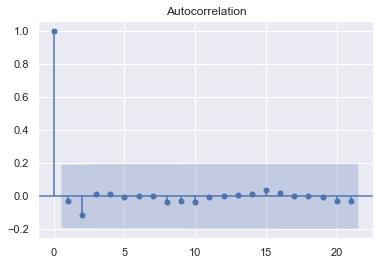

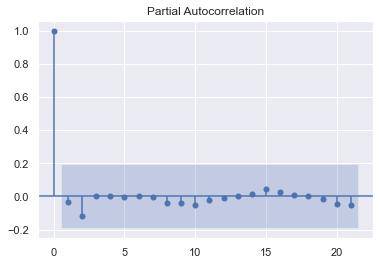

In [12]:
mod=ARIMA(dfEU_Growth.dropna(), order=(1,0,0)).fit()
plot_acf(mod.resid), plot_pacf(mod.resid);

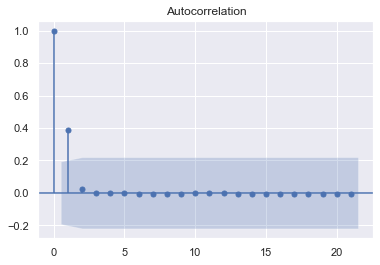

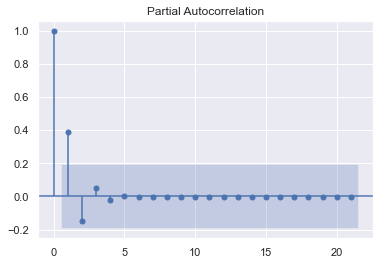

In [13]:
plot_acf(mod.resid**2), plot_pacf(mod.resid**2);

In [14]:
# Save DataFrame
dfEU_Growth.to_pickle('EU_Growth.pkl')